<div style="text-align:center">
    <h1>TZO investigations</h1>
    <p style="text-align:center">Maybe Lauryn/Emily might like this</p>
</div>

In [1]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("default")


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load the population

In [8]:
import h5py as h5

In [47]:
with h5.File("/mnt/home/twagg/ceph/pops/m11h-r-3-no-gal.h5", "a") as f:
    f.create_group("sampling_params")

In [11]:
%%time
p = cogsworth.pop.load("/mnt/home/twagg/ceph/pops/m11h-r-3-new-pot.h5")

CPU times: user 6.86 s, sys: 3.76 s, total: 10.6 s
Wall time: 19 s


In [12]:
from importlib import reload
import sys
sys.path.append("../src")
import plotting

In [13]:
reload(plotting)
plotting.set_sn_subpop_masks(p)

12056 177097 114777 225314


(0         False
 3         False
 4         False
 8         False
 10        False
           ...  
 776937    False
 776942    False
 776946    False
 776947    False
 776953    False
 Name: bin_num, Length: 245280, dtype: bool,
 0         False
 1         False
 4         False
 6         False
 9         False
           ...  
 776951    False
 776953    False
 776955    False
 776958    False
 776961    False
 Name: bin_num, Length: 283964, dtype: bool,
 0          True
 3          True
 4          True
 8          True
 10         True
           ...  
 776937     True
 776942     True
 776946    False
 776947    False
 776953     True
 Name: bin_num, Length: 245280, dtype: bool,
 0         False
 3         False
 4         False
 8         False
 10        False
           ...  
 776937    False
 776942    False
 776946     True
 776947     True
 776953    False
 Name: bin_num, Length: 245280, dtype: bool,
 0          True
 1         False
 4          True
 6         False
 9  

# TZOs?

Mask for TZO candidates needs something like:
- Has a SN
- SN occurs just before (1 Myr?) before a coalescence
- System ends as a NS

In [6]:
has_an_sn = p.bpp[((p.bpp["evol_type"] == 15) | (p.bpp["evol_type"] == 16)) & ~p.bpp["bin_num"].isin(p.duplicate_sn)]["bin_num"].values
has_a_merger = p.bpp[p.bpp["evol_type"] == 6]["bin_num"].values
sn_mergers = p.bin_nums[np.isin(p.bin_nums, has_an_sn) & np.isin(p.bin_nums, has_a_merger)]

In [7]:
def is_tzo_candidate(df):
    sn_times = df[df["evol_type"].isin([15, 16])]["tphys"].values
    merge_time = df[df["evol_type"] == 6]["tphys"].min()
    return np.any((sn_times <= merge_time) & (sn_times > merge_time - 1)) & ((df.iloc[-1]["kstar_1"] == 13) | (df.iloc[-1]["kstar_2"] == 13))

In [8]:
sn_merger_rows_for_mask = p.bpp.loc[sn_mergers][["tphys", "evol_type", "bin_num", "kstar_1", "kstar_2"]]

In [9]:
%%time
mask = sn_merger_rows_for_mask.groupby("bin_num").apply(is_tzo_candidate)

CPU times: user 1min 9s, sys: 381 ms, total: 1min 9s
Wall time: 1min 9s


In [10]:
tzo_candidates = mask[mask].index.values

In [11]:
%%time
tzos = p[tzo_candidates]

CPU times: user 1.74 s, sys: 112 ms, total: 1.86 s
Wall time: 1.84 s


In [12]:
bns_or_merger_nums = p.bpp[(p.bpp["kstar_1"] == 13) & (p.bpp["kstar_2"] == 13) & ((p.bpp["evol_type"] == 6) | (p.bpp["sep"] > 0))]["bin_num"].unique()

In [13]:
len(bns_or_merger_nums)

233

In [14]:
bns = p[p.bin_nums[((p.final_bpp["kstar_1"] == 13) & (p.final_bpp["kstar_2"] == 13) & (p.final_bpp["sep"] > 0))]]

# Distribution plots

## Kick things

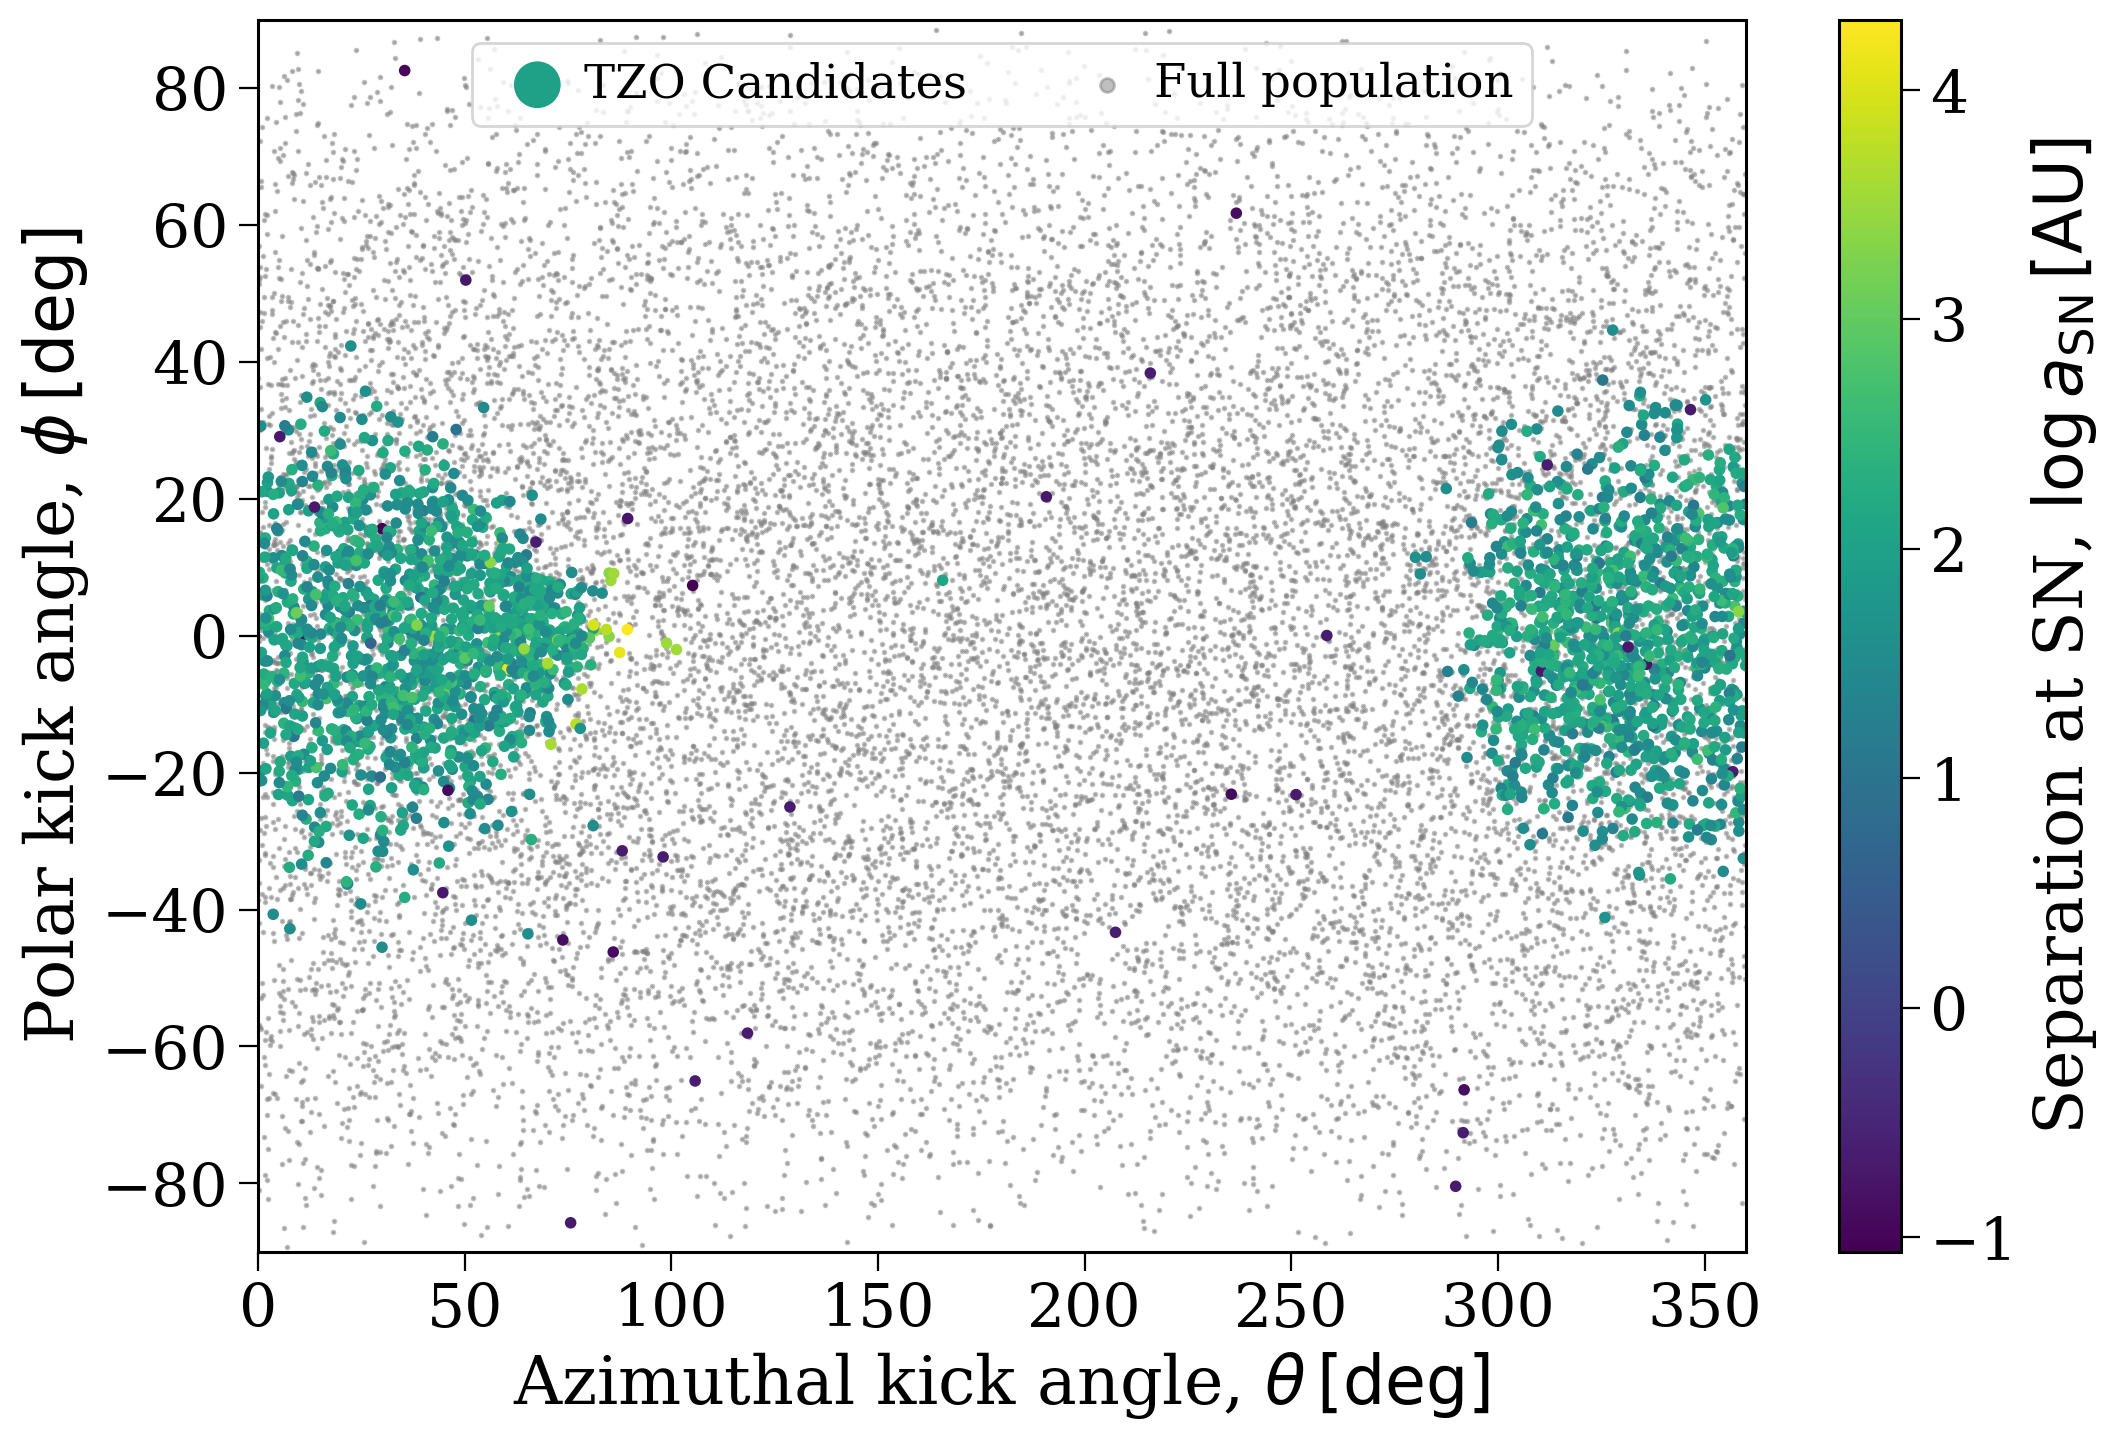

In [17]:
fig, ax = plt.subplots()

actual_kicks = tzos.kick_info["natal_kick"] > 0.0
scatter = ax.scatter(tzos.kick_info["theta"][actual_kicks], tzos.kick_info["phi"][actual_kicks],
            s=10, c=np.log10(tzos.bpp[tzos.bpp["evol_type"].isin([15, 16])]["sep"]),
            cmap="viridis", label="TZO Candidates")
fig.colorbar(scatter, label=r"Separation at SN, $\log a_{\rm SN} \, {\rm [AU]}$")

ax.scatter(p.kick_info["theta"].values[::50], p.kick_info["phi"][::50], s=1, c='grey', alpha=0.5, label="Full population", zorder=-1)

ax.set(xlabel=r"Azimuthal kick angle, $\theta \, [\rm deg]$",
       ylabel=r"Polar kick angle, $\phi \, [\rm deg]$", xlim=(0, 360), ylim=(-90, 90))
ax.legend(loc='upper center', fontsize=0.7*fs, markerscale=5, handletextpad=0.0, ncol=2)

plt.show()

In [16]:
len(tzos)

2327

## Initial conditions

In [113]:
tzos.initC

,kstar_1,kstar_2,mass_1,mass_2,porb,ecc,metallicity,binfrac,tphysf,mass0_1,mass0_2,rad_1,rad_2,lum_1,lum_2,massc_1,massc_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,tms_1,tms_2,bhspin_1,bhspin_2,tphys,neta,bwind,hewind,alpha1,lambdaf,ceflag,tflag,ifflag,wdflag,pisn,rtmsflag,bhflag,remnantflag,grflag,bhms_coll_flag,cekickflag,cemergeflag,cehestarflag,mxns,pts1,pts2,pts3,ecsn,ecsn_mlow,aic,ussn,sigma,sigmadiv,bhsigmafrac,polar_kick_angle,beta,xi,acc2,epsnov,eddfac,gamma,don_lim,acc_lim,bdecayfac,bconst,ck,windflag,qcflag,eddlimflag,dtp,randomseed,bhspinflag,bhspinmag,rejuv_fac,rejuvflag,htpmb,ST_cr,ST_tide,rembar_massloss,zsun,kickflag,bin_num,natal_kick_1,phi_1,theta_1,mean_anomaly_1,randomseed_1,natal_kick_2,phi_2,theta_2,mean_anomaly_2,randomseed_2,qcrit_0,qcrit_1,qcrit_2,qcrit_3,qcrit_4,qcrit_5,qcrit_6,qcrit_7,qcrit_8,qcrit_9,qcrit_10,qcrit_11,qcrit_12,qcrit_13,qcrit_14,qcrit_15,fprimc_0,fprimc_1,fprimc_2,fprimc_3,fprimc_4,fprimc_5,fprimc_6,fprimc_7,fprimc_8,fprimc_9,fprimc_10,fprimc_11,fprimc_12,fprimc_13,fprimc_14,fprimc_15,particle_id
59,1.0,1.0,12.286670,7.076965,1911.891842,0.220314,0.014378,0.5,200.880562,12.286670,7.076965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,1.0,0.0,0,1,0,1,45.0,0,1,4,1,0,2,0,0,3.0,0.001,0.01,0.02,2.25,1.6,1,0,265.0,-20.0,1.0,90,-1.0,1.0,1.5,0.001,1.0,-2.0,-1,-1,1,3000,1000,3,5,0,200.880562,632805212,0,0.0,1.0,0,1,1,1,0.5,0.014,0,59,201.987225,-11.403244,319.438198,237.740064,-6.328052e+08,-100.0,-100.0,-100.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0
706,1.0,1.0,13.317908,10.659519,189.489642,0.055267,0.017368,0.5,201.450758,13.317908,10.659519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,1.0,0.0,0,1,0,1,45.0,0,1,4,1,0,2,0,0,3.0,0.001,0.01,0.02,2.25,1.6,1,0,265.0,-20.0,1.0,90,-1.0,1.0,1.5,0.001,1.0,-2.0,-1,-1,1,3000,1000,3,5,0,201.450758,-1995116901,0,0.0,1.0,0,1,1,1,0.5,0.014,0,706,312.881055,16.594630,1.178365,215.435457,-1.995117e+09,-100.0,-100.0,-100.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,2
1226,1.0,1.0,33.513857,18.468768,3.956964,0.001236,0.016167,0.5,327.070555,33.513857,18.468768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,1.0,0.0,0,1,0,1,45.0,0,1,4,1,0,2,0,0,3.0,0.001,0.01,0.02,2.25,1.6,1,0,265.0,-20.0,1.0,90,-1.0,1.0,1.5,0.001,1.0,-2.0,-1,-1,1,3000,1000,3,5,0,327.070555,-98241577,0,0.0,1.0,0,1,1,1,0.5,0.014,0,1226,369.453488,12.555235,341.080406,131.146524,-9.824158e+07,-100.0,-100.0,-100.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,4
1386,1.0,1.0,20.389035,13.899385,9.556048,0.109049,0.019613,0.5,338.760206,20.389035,13.899385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,1.0,0.0,0,1,0,1,45.0,0,1,4,1,0,2,0,0,3.0,0.001,0.01,0.02,2.25,1.6,1,0,265.0,-20.0,1.0,90,-1.0,1.0,1.5,0.001,1.0,-2.0,-1,-1,1,3000,1000,3,5,0,338.760206,-18910051,0,0.0,1.0,0,1,1,1,0.5,0.014,0,1386,176.734730,-16.053511,38.853970,112.392873,-1.891005e+07,-100.0,-100.0,-100.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238,5
2390,1.0,1.0,11.432683,8

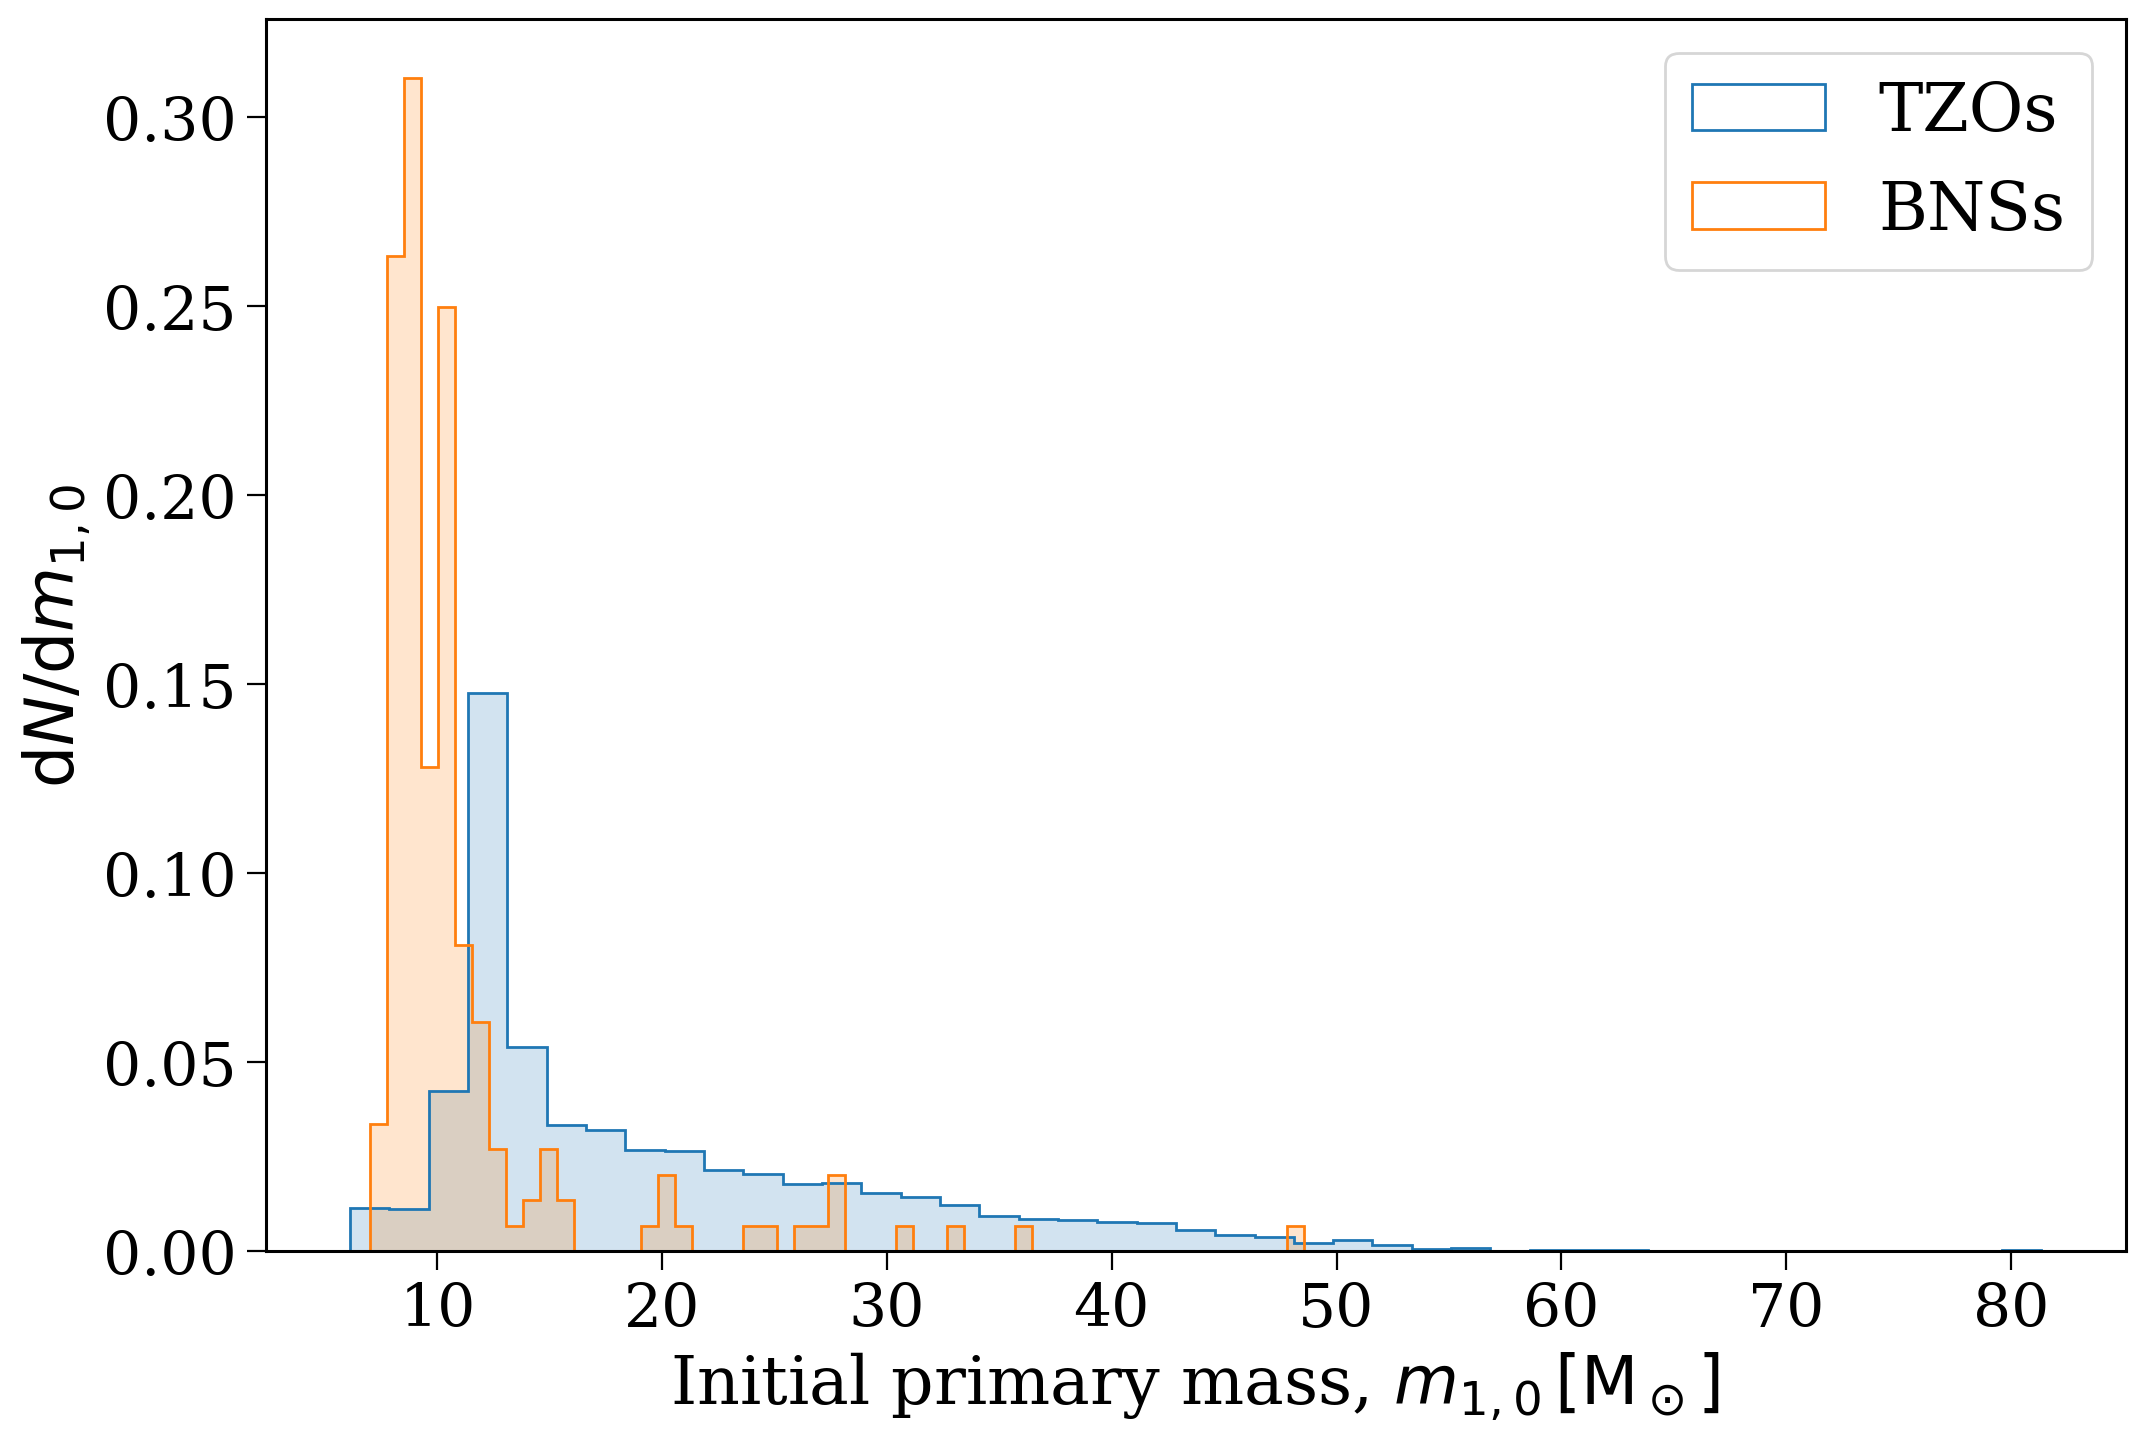

In [23]:
fig, ax = plt.subplots()

for pop, c, l in zip([tzos, bns], ['C0', 'C1'], ["TZOs", "BNSs"]):
    ax.hist(pop.initC["mass_1"], bins="fd", density=True, alpha=0.2, color=c)
    ax.hist(pop.initC["mass_1"], bins="fd", density=True, histtype="step", label=l, color=c)
    
ax.legend()

ax.set_xlabel(r"Initial primary mass, $m_{1, 0} \, [\rm M_\odot]$")
ax.set_ylabel(r"$\mathrm{d}N/\mathrm{d}m_{1, 0}$")

plt.show()

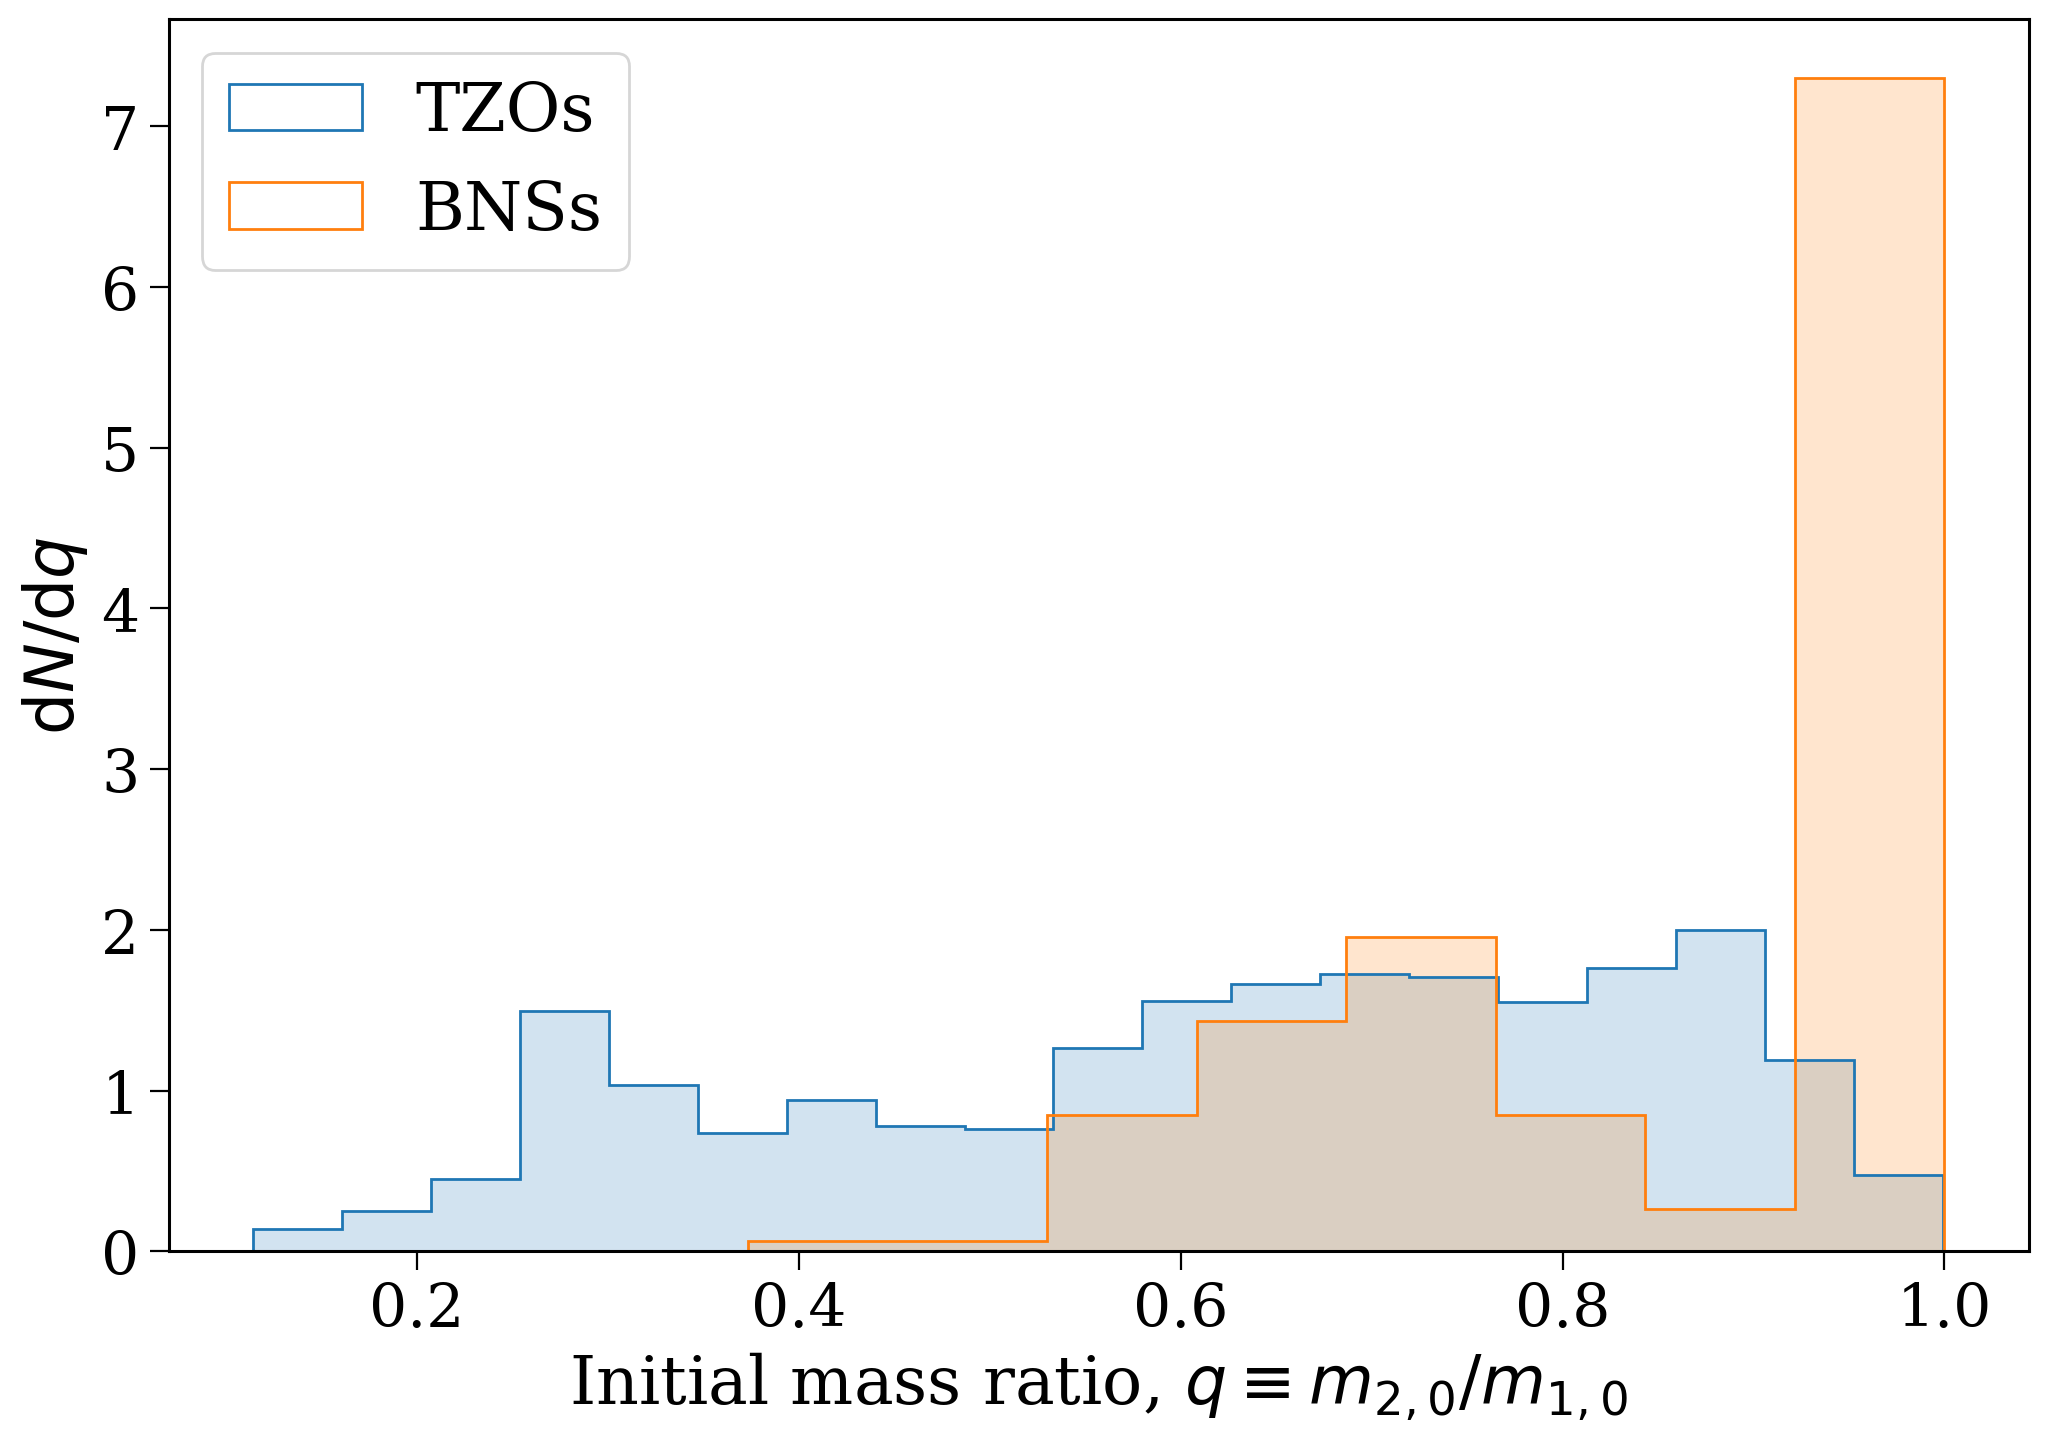

In [24]:
fig, ax = plt.subplots()

for pop, c, l in zip([tzos, bns], ['C0', 'C1'], ["TZOs", "BNSs"]):
    q = pop.initC["mass_2"] / pop.initC["mass_1"]
    ax.hist(q, bins="fd", density=True, alpha=0.2, color=c)
    ax.hist(q, bins="fd", density=True, histtype="step", label=l, color=c)
    
ax.legend()

ax.set_xlabel(r"Initial mass ratio, $q \equiv m_{2, 0} / m_{1, 0}$")
ax.set_ylabel(r"$\mathrm{d}N/\mathrm{d}q$")

plt.show()

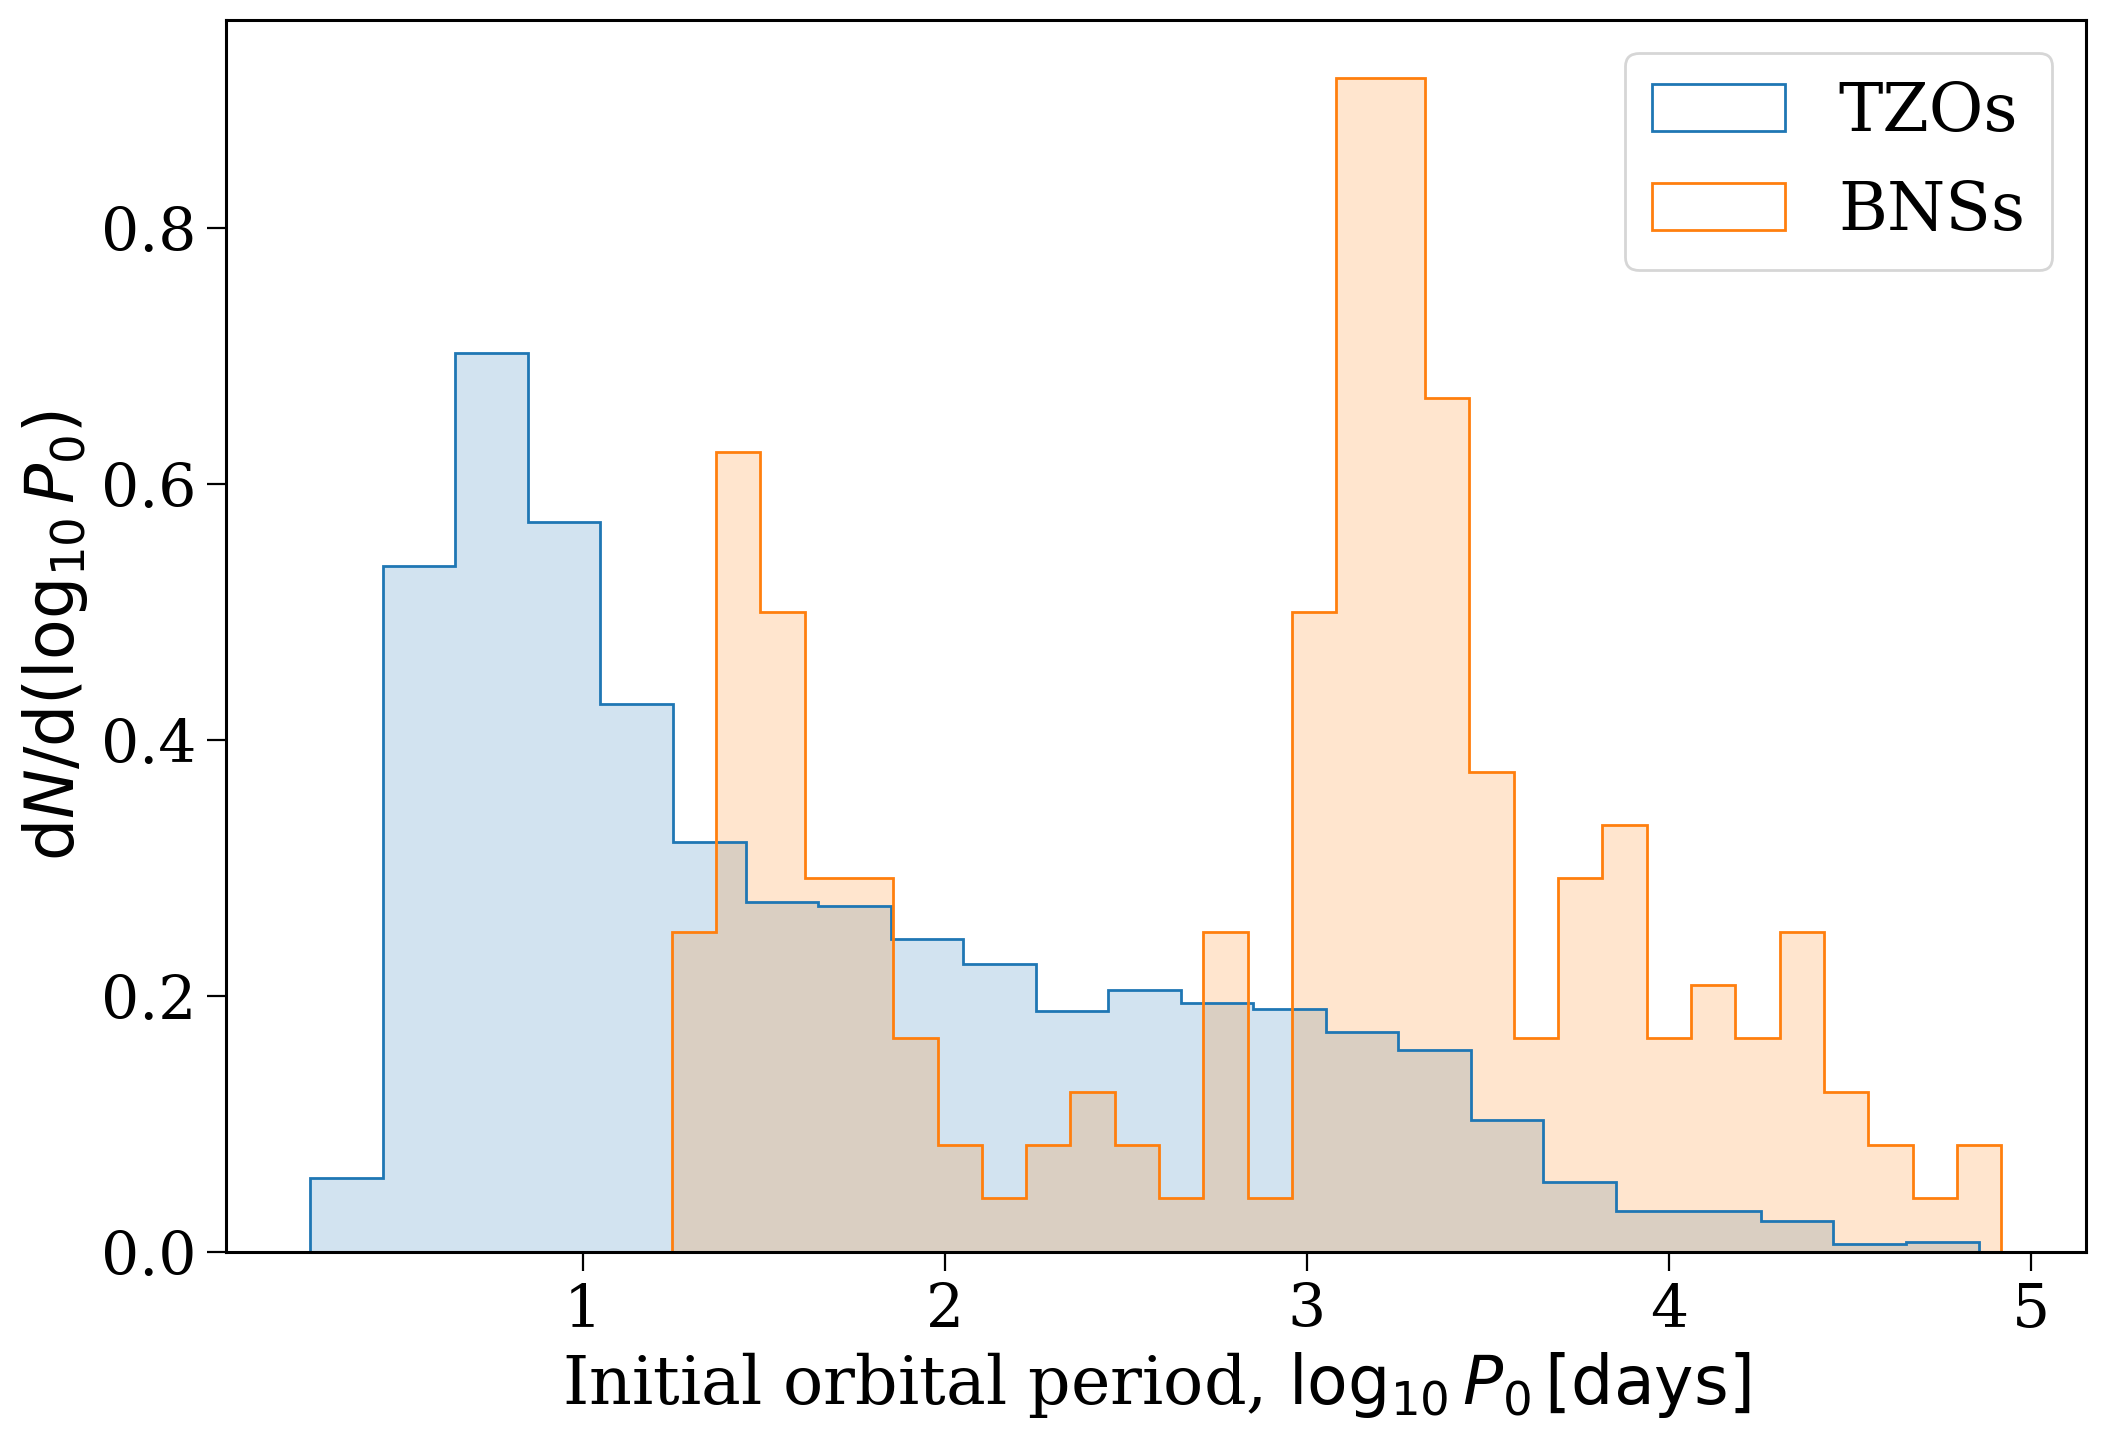

In [36]:
fig, ax = plt.subplots()

for pop, c, l, b in zip([tzos, bns], ['C0', 'C1'], ["TZOs", "BNSs"], ['fd', 30]):
    q = pop.initC["mass_2"] / pop.initC["mass_1"]
    ax.hist(np.log10(pop.initC["porb"]), bins=b, density=True, alpha=0.2, color=c)
    ax.hist(np.log10(pop.initC["porb"]), bins=b, density=True, histtype="step", label=l, color=c)
    
ax.legend()

ax.set_xlabel(r"Initial orbital period, $\log_{10}P_{0} \, [\rm days]$")
ax.set_ylabel(r"$\mathrm{d}N/\mathrm{d} (\log_{10}P_{0})$")

plt.show()

In [37]:
bns

<Population - 196 systems - galactic_potential=CompositePotential, SFH=Galaxy>

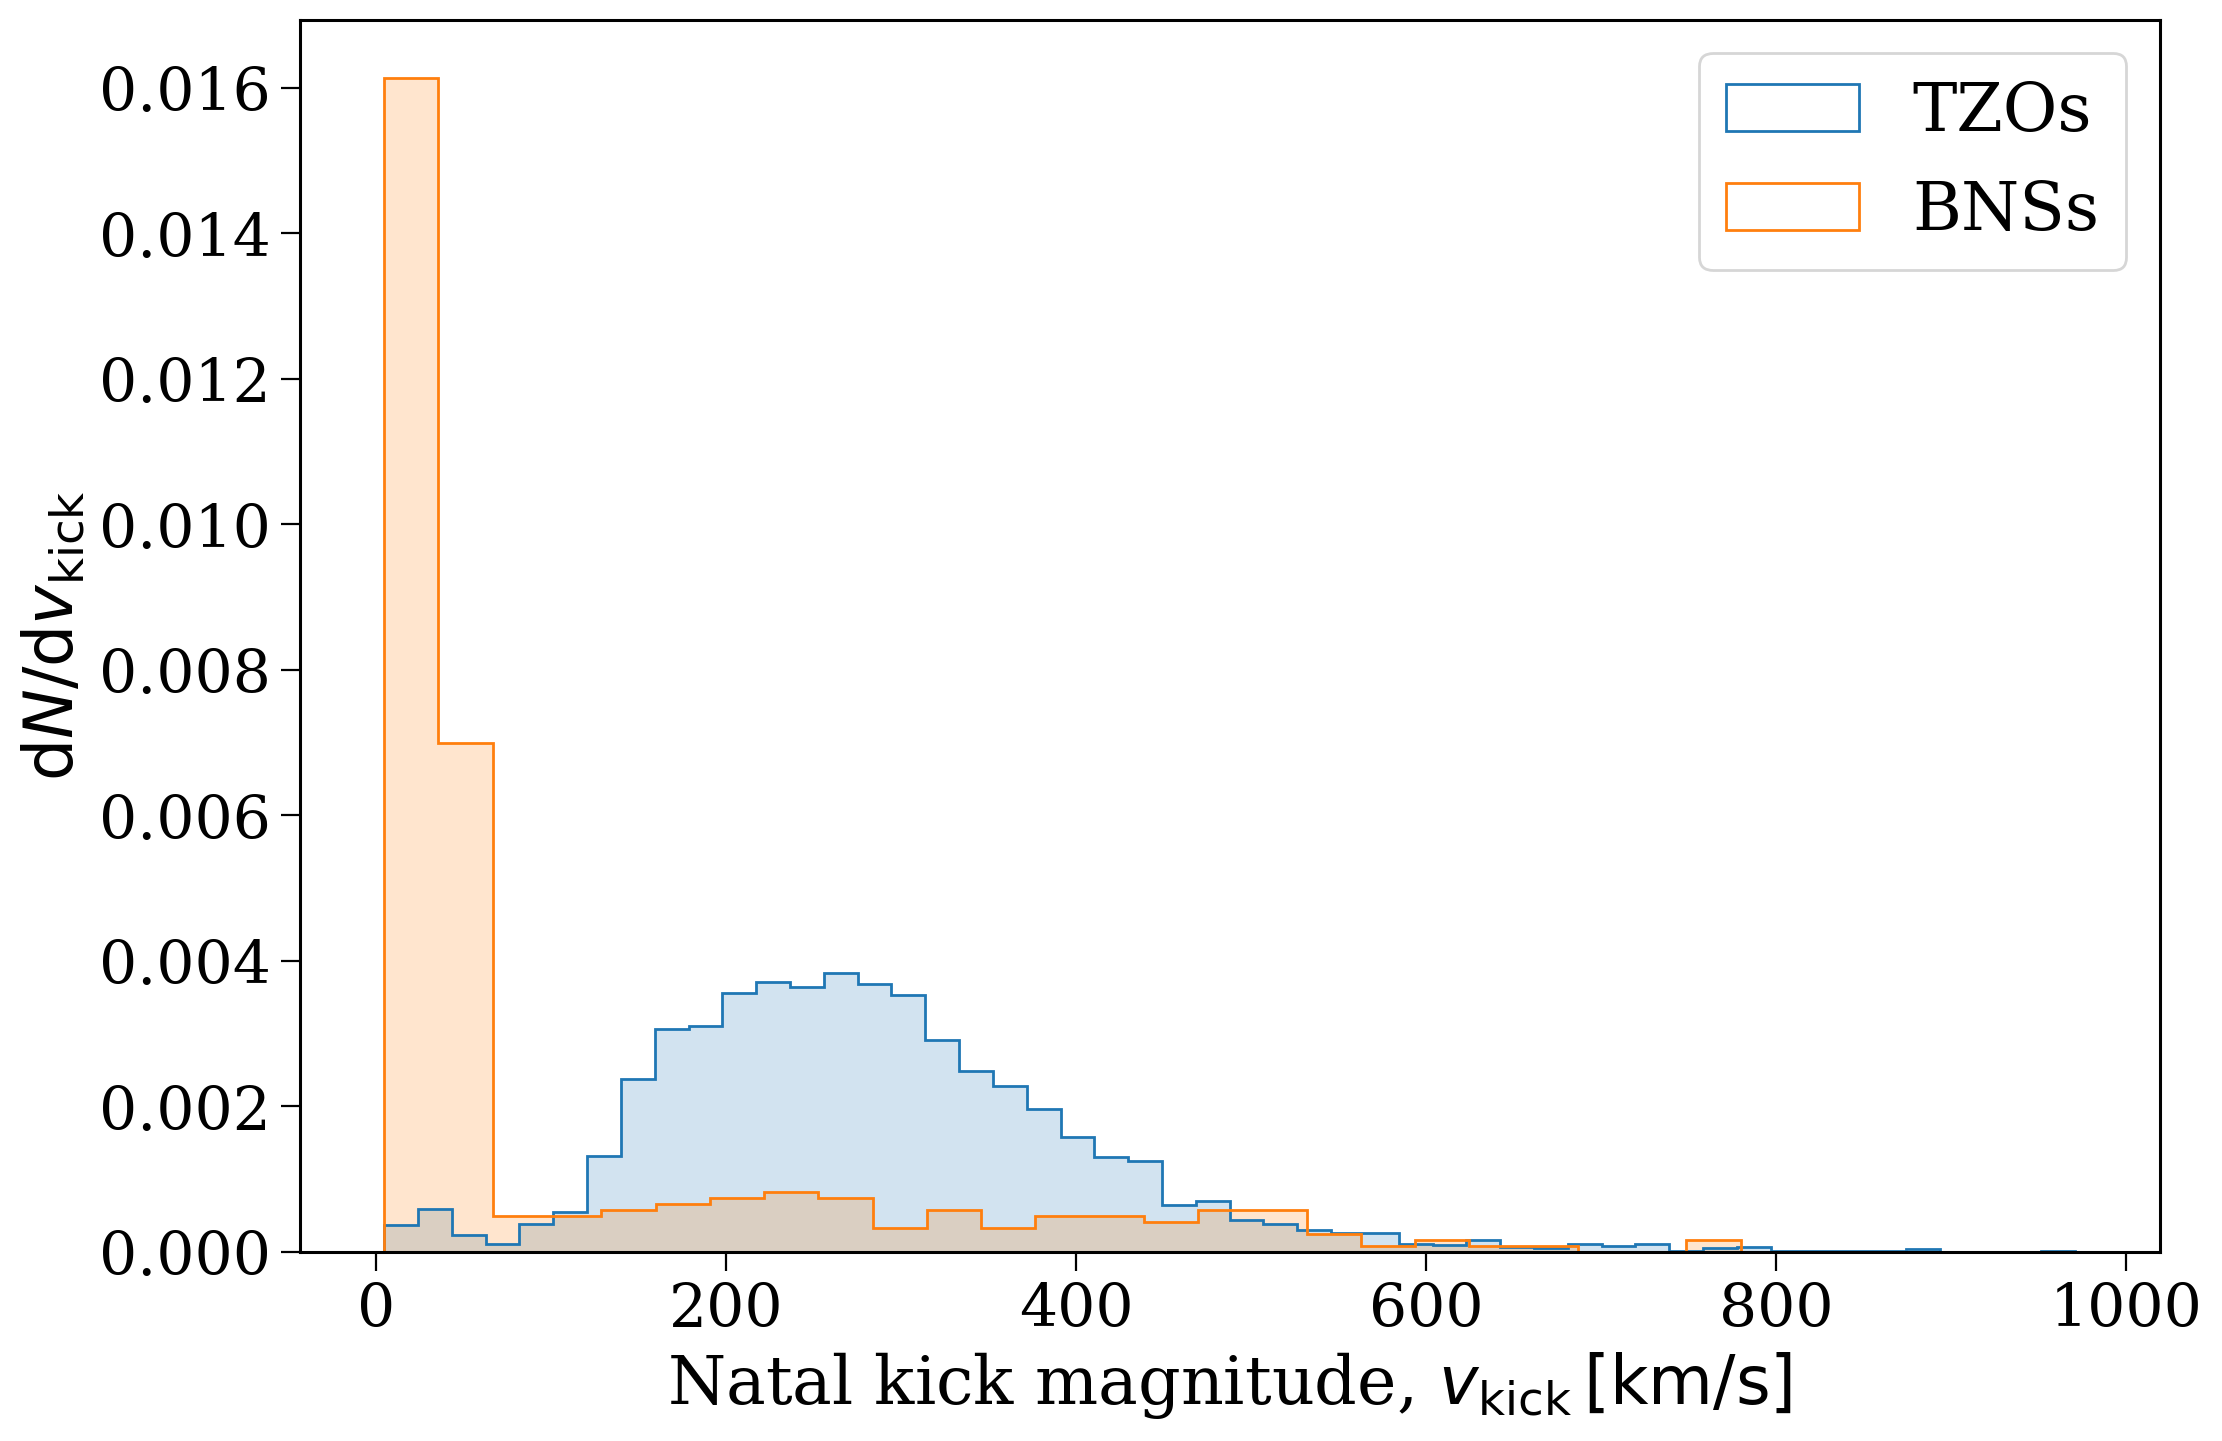

In [27]:
fig, ax = plt.subplots()

for pop, c, l in zip([tzos, bns], ['C0', 'C1'], ["TZOs", "BNSs"]):
    kicks = pop.kick_info["natal_kick"].values
    kicks = kicks[kicks > 0.0]
    ax.hist(kicks, bins="fd", density=True, alpha=0.2, color=c)
    ax.hist(kicks, bins="fd", density=True, histtype="step", label=l, color=c)
    
ax.legend()

ax.set_xlabel(r"Natal kick magnitude, $v_{\rm kick} \, [\rm km / s]$")
ax.set_ylabel(r"$\mathrm{d}N/\mathrm{d}v_{\rm kick}$")

plt.show()

# Energy information

Things we'd like to know:

- Kick velocities
- Orbital separation and eccentricity at moment of supernova
- Secondary star radius
- Secondary star mass

In [48]:
tzo_kicks = tzos.kick_info.drop_duplicates(subset="bin_num")

In [35]:
tzo_sn_states = tzos.bpp[tzos.bpp["evol_type"].isin([15, 16])]

In [59]:
tzos.bpp.loc[48781]

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2,bin_num
48781,0.000000,7.222050,3.987189,1.0,1.0,1.996301e+03,3.087614e+03,0.336355,0.006022,0.005614,1.0,0.000000,0.000000,4.497651e+01,185.494253,0.000000,0.000000,3.440305,2.445538,7.222050,3.987189,1914.484592,226.723207,2.067684e+04,14386.540449,0.000000,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,3.159603e+03,5.408673e+03,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,48781
48781,45.294305,7.156445,3.986767,2.0,1.0,2.008129e+03,3.124313e+03,0.336355,0.014039,0.006286,2.0,45.874673,45.300712,4.587467e+01,185.544862,1.369898,0.000000,8.052291,2.760809,7.156445,3.986767,5739.427597,255.088629,1.778390e+04,13945.183118,0.257831,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,6.632906e+02,4.240377e+03,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,-0.580368,-0.006407,0.0,0.0,48781
48781,45.439182,7.155679,3.986768,3.0,1.0,2.008269e+03,3.124745e+03,0.336356,0.200675,0.006288,2.0,46.030242,45.445583,4.588534e+01,185.544835,1.397130,0.000000,115.105644,2.761984,7.155679,3.986768,2907.684686,255.200513,3.968333e+03,13943.745775,0.261464,0.000000,2.879466e+00,1.000000e-10,7.465139e+01,1.000000e-10,2.444632e+00,4.236778e+03,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,-0.591060,-0.006400,0.0,0.0,48781
48781,45.492042,7.153558,3.986808,4.0,1.0,2.006322e+03,3.120495e+03,0.335559,0.469628,0.006287,2.0,46.083102,45.497255,4.588534e+01,185.539990,1.397847,0.000000,269.420177,2.762428,7.155679,3.986808,9706.264653,255.251071,3.506046e+03,13943.315230,0.261560,0.000000,5.755711e+00,1.000000e-10,2.691586e+02,1.000000e-10,4.908031e-01,4.235765e+03,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,-0.591060,-0.005213,0.0,0.0,48781
48781,51.212372,6.909797,3.990700,5.0,1.0,2.004793e+03,3.151037e+03,0.308408,0.421486,0.006098,2.0,51.803432,51.098838,4.588534e+01,185.073898,1.846474,0.000000,249.639091,2.811639,7.155679,3.990700,7369.118827,260.751890,3.399908e+03,13894.621358,0.317425,0.000000,5.063323e+00,1.000000e-10,2.493217e+02,1.000000e-10,5.310928e-01,4.142158e+03,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,-0.591060,0.113535,0.0,0.0,48781
48781,51.484032,6.827630,3.995860,6.0,1.0,1.726411e+03,2.526997e+03,0.000061,0.900281,0.004889,2.0,52.075092,51.199919,4.588534e+01,184.458598,1.260449,0.000000,662.073963,2.815940,7.155679,3.995860,29590.284860,262.247193,2.955314e+03,13903.867969,0.024246,0.000000,5.567182e+00,1.000000e-10,6.620497e+02,1.000000e-10,7.899852e-01,4.464849e+03,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,-0.591060,0.284113,0.0,0.0,48781
48781,51.552772,6.748092,4.003884,6.0,1.0,1.685822e+03,2.446502e+03,0.000000,1.000995,0.004996,3.0,52.143832,51.004527,4.588534e+01,183.507627,1.263173,0.000000,716.820034,2.819592,7.155679,4.003884,32929.332240,264.292196,2.917160e+03,13921.870094,0.024048,0.000000,5.484919e+00,1.000000e-10,7.167960e+02,1.000000e-10,9.380212e-01,9.380212e-01,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,-0.591060,0.548245,0.0,0.0,48781
48781,51.552772,6.748092,4.003884,6.0,1.0,1.685822e+03,2.446502e+03,0.000000,1.000995,0.004996,7.0,52.143832,51.004527,4.588534e+01,183.507627,1.263173,0.000000,716.820034,2.819592,7.155679,4.003884,32929.332240,264.292196,2.917160e+03,13921.870094,0.024048,0.000000,5.484919e+00,1.000000e-10,7.167960e+02,1.000000e-10,9.380212e-01,9.380212e-01,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,-0.591060,0.548245,0.0,0.0,48781
48781,51.552772,1.263173,4.003884,12.0,1.0,5.115430e+01,1.847614e+01,0.000000,1.000995,0.004996,8.0,0.000000,51.004527,4.588534e+01,183.507627,1.263173,0.000000,716.820034,2.819592,1.263173,4.003884,32929.332240,264.292196,2.917160e+03,13921.870094,0.024048,0.000000,5.484919e+00,1.000000e-10,7.167960e+02,1.000000e-10,9.380212e-01,9.3802

In [57]:
tzo_sn_states[tzo_kicks["natal_kick"] < 40]

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2,bin_num
798,122.032800,1.380016,3.741674,12.0,6.0,6292.387612,25561.639935,0.000000,9.487140e-07,0.193865,15.0,76.677641,102.424530,1.000000e+10,88.296514,1.379939,1.026496,0.000088,842.991355,1.367133,5.368780,0.018278,38665.096166,226997.024395,2800.192088,0.000088,0.038793,1.000000e-10,2.680884,1.000000e-10,837.379213,1.238308e+12,0.005718,0.0,0.0,0.0,0.0,0.0,0.0,45.354440,19.607551,0.0,0.0,798
48781,254.802693,1.382285,0.517151,12.0,7.0,0.234331,0.009539,0.000000,1.695119e-02,1.001101,15.0,69.804518,129.193960,1.000000e+10,128.206048,1.379687,0.000000,0.000200,0.117647,1.269475,0.517151,0.021937,47.305977,157720.811159,44330.997669,0.000200,0.000000,1.000000e-10,0.519750,1.000000e-10,0.117647,1.061077e+10,217578.527382,0.0,0.0,0.0,0.0,0.0,0.0,184.975565,125.586123,0.0,0.0,48781
72807,215.265664,1.381219,0.438808,12.0,7.0,0.124412,0.003770,0.000000,2.426454e-02,1.000653,15.0,15.356767,43.657761,1.000000e+10,232.934251,1.379014,0.000000,0.000355,0.103404,1.367821,0.438808,0.123847,11.283063,182532.800700,33045.155512,0.000355,0.000000,1.000000e-10,0.441013,1.000000e-10,0.103404,4.655126e+09,519727.884505,0.0,0.0,0.0,0.0,0.0,0.0,199.882809,171.581815,0.0,0.0,72807
79506,236.628644,1.380645,0.391132,12.0,7.0,0.128648,0.004018,0.000000,2.502326e-02,1.000588,15.0,163.207902,163.677525,1.000000e+10,375.588356,1.378679,0.000000,0.000411,0.097737,1.335045,0.391132,0.005378,7.550730,77460.026251,30742.326636,0.000411,0.000000,1.000000e-10,0.393097,1.000000e-10,0.097737,3.501936e+09,477060.763926,0.0,0.0,0.0,0.0,0.0,0.0,73.387973,72.918350,0.0,0.0,79506
80256,171.125998,1.380451,0.464385,12.0,7.0,0.209478,0.008181,0.000000,3.102176e-02,1.000617,15.0,107.917084,32.101663,1.000000e+10,187.590143,1.378118,0.000000,0.000491,0.110087,1.268757,0.464385,0.011758,14.534333,86195.575157,34119.384611,0.000491,0.000000,1.000000e-10,0.466719,1.000000e-10,0.110087,2.612474e+09,234444.473597,0.0,0.0,0.0,0.0,0.0,0.0,63.187609,139.003031,0.0,0.0,80256
85369,133.199233,1.380010,3.065009,12.0,6.0,3268.224181,10270.772698,0.000000,3.149942e-06,0.374585,15.0,86.143082,107.808543,1.000000e+10,92.755498,1.379940,1.006312,0.000087,900.938259,1.337564,5.261447,0.016588,34695.387994,222733.644978,2636.270884,0.000087,0.039935,1.000000e-10,1.976416,1.000000e-10,888.436998,1.231773e+12,0.157738,0.0,0.0,0.0,0.0,0.0,0.0,47.055495,25.390034,0.0,0.0,85369
105243,187.960970,1.381831,0.433573,12.0,7.0,0.228444,0.009392,0.000000,3.025959e-02,1.000460,15.0,122.889971,79.996151,1.000000e+10,244.243735,1.379652,0.000000,0.000211,0.107941,1.261128,0.433573,0.010130,11.783255,126687.012482,32695.840233,0.000211,0.000000,1.000000e-10,0.435752,1.000000e-10,0.107941,1.246232e+10,206513.428002,0.0,0.0,0.0,0.0,0.0,0.0,65.044423,107.938243,0.0,0.0,105243
185793,242.161389,1.381560,0.481920,12.0,7.0,0.223962,0.008999,0.000000,1.688812e-02,1.000422,15.0,13.915647,23.049741,1.000000e+10,163.834652,1.379138,0.000000,0.000332,0.113452,1.300230,0.481920,0.139544,16.823007,194522.779665,34860.995233,0.000332,0.000000,1.000000e-10,0.484342,1.000000e-10,0.113452,2.624753e+09,225368.622488,0.0,0.0,0.0,0.0,0.0,0.0,228.223494,219.089400,0.0,0.0,185793
186294,169.152031,1.381611,0.462414,12.0,7.0,0.221178,0.008878,0.000000,3.168914e-02,1.000721,15.0,104.536211,36.789013,1.000000e+10,190.586803,1.379288,0.000000,0.000302,0.110561,1.255836,0.462414,0.012824,14.462764,112321.154103,34004.173511,0.000302,0.000000,1.000000e-10,0.464738,1.000000e-10,0.110561,6.366086e+09,216771.855482,0.0,0.0,0.0,0.0,0.0,0.0,64.594682,132.341880,0.0,0.0,186294
187706,202.545337,1.381683,0.468129,12.0,7.0,0.119200,0.003507,0.000000,2.291742e-02,1.000229,15.0,4.311244,9.082096,1.000000e+10,182.093557,1.379330,0.00000

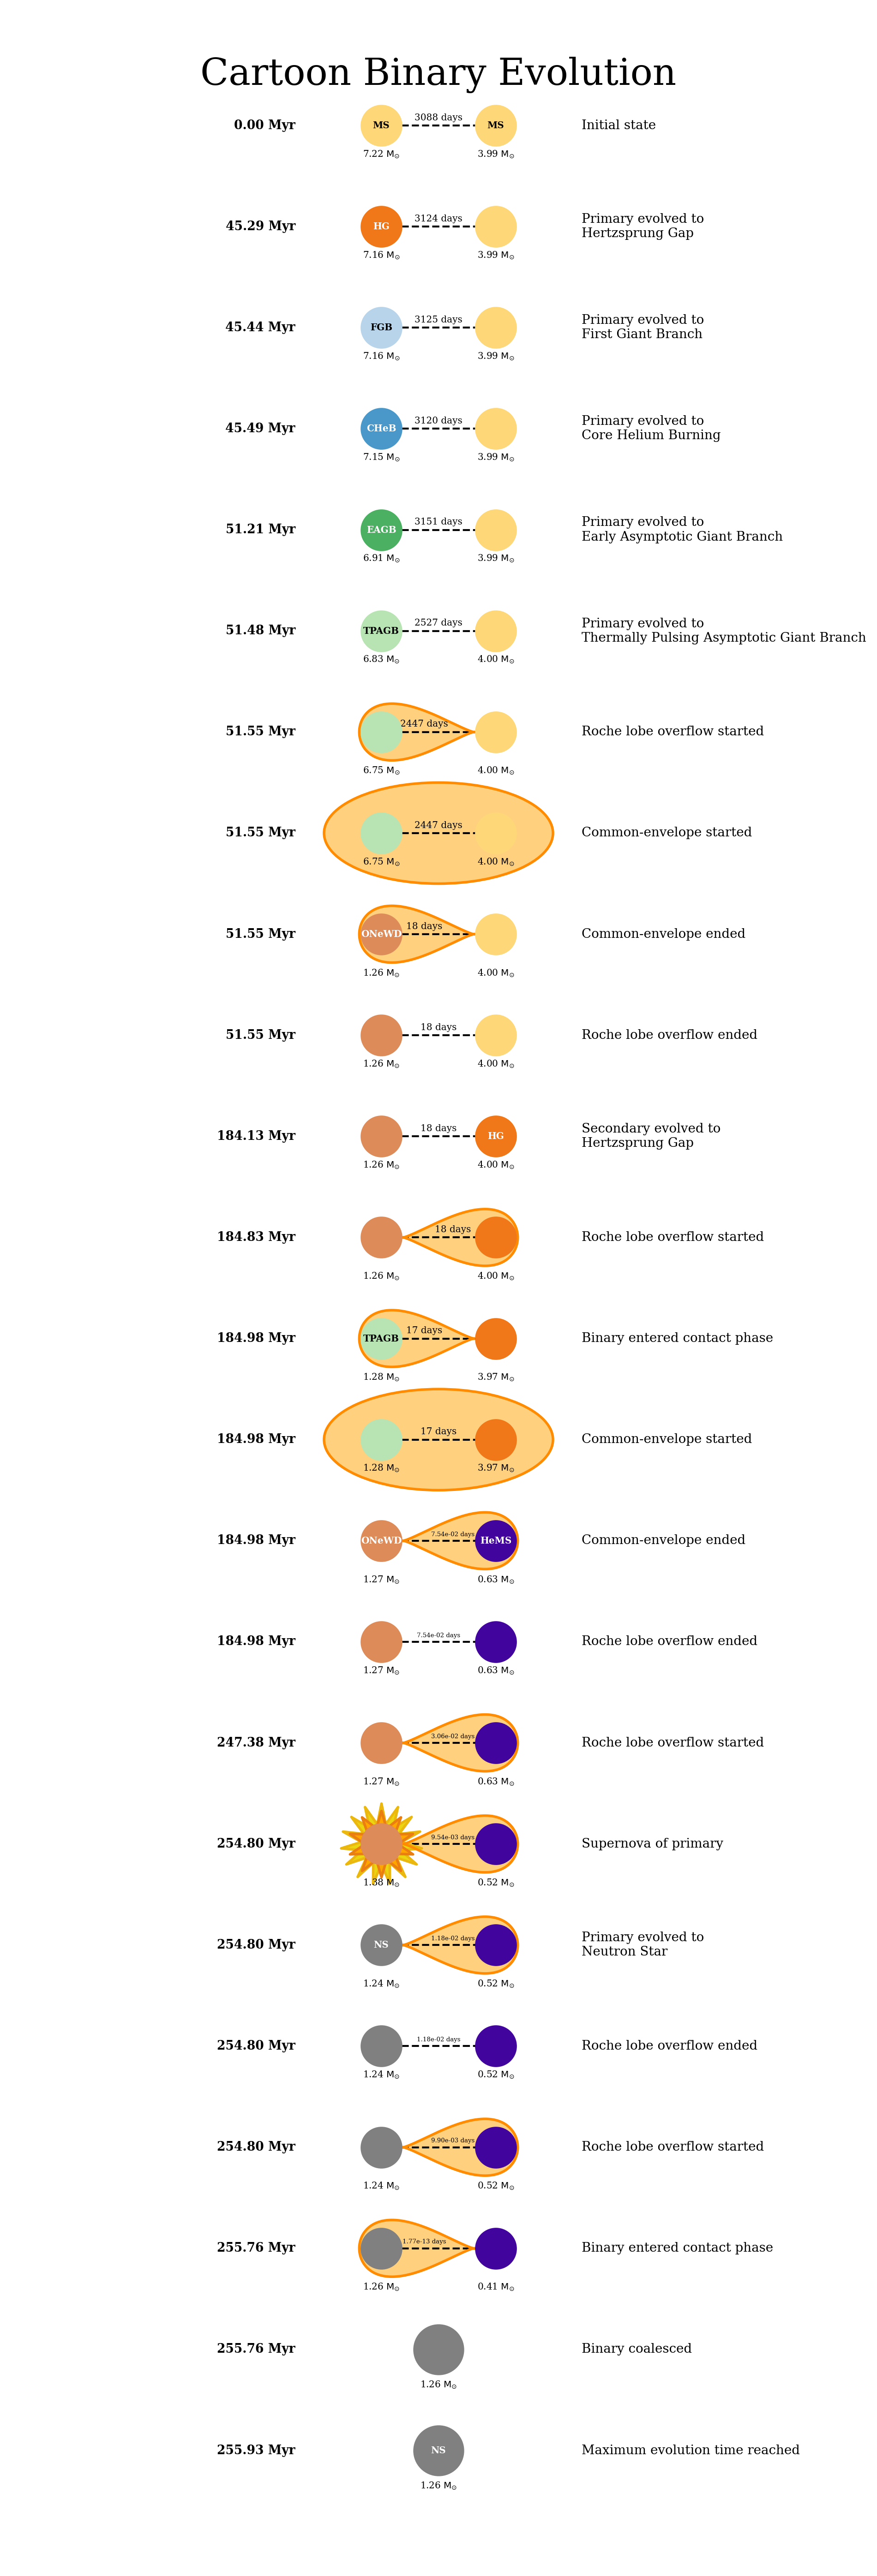

(<Figure size 1200x3600 with 1 Axes>, <Axes: >)

In [66]:
tzos.plot_cartoon_binary(48781)

In [65]:
tzos.bpp.loc[48781]

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2,bin_num
48781,0.000000,7.222050,3.987189,1.0,1.0,1.996301e+03,3.087614e+03,0.336355,0.006022,0.005614,1.0,0.000000,0.000000,4.497651e+01,185.494253,0.000000,0.000000,3.440305,2.445538,7.222050,3.987189,1914.484592,226.723207,2.067684e+04,14386.540449,0.000000,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,3.159603e+03,5.408673e+03,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,48781
48781,45.294305,7.156445,3.986767,2.0,1.0,2.008129e+03,3.124313e+03,0.336355,0.014039,0.006286,2.0,45.874673,45.300712,4.587467e+01,185.544862,1.369898,0.000000,8.052291,2.760809,7.156445,3.986767,5739.427597,255.088629,1.778390e+04,13945.183118,0.257831,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,6.632906e+02,4.240377e+03,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,-0.580368,-0.006407,0.0,0.0,48781
48781,45.439182,7.155679,3.986768,3.0,1.0,2.008269e+03,3.124745e+03,0.336356,0.200675,0.006288,2.0,46.030242,45.445583,4.588534e+01,185.544835,1.397130,0.000000,115.105644,2.761984,7.155679,3.986768,2907.684686,255.200513,3.968333e+03,13943.745775,0.261464,0.000000,2.879466e+00,1.000000e-10,7.465139e+01,1.000000e-10,2.444632e+00,4.236778e+03,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,-0.591060,-0.006400,0.0,0.0,48781
48781,45.492042,7.153558,3.986808,4.0,1.0,2.006322e+03,3.120495e+03,0.335559,0.469628,0.006287,2.0,46.083102,45.497255,4.588534e+01,185.539990,1.397847,0.000000,269.420177,2.762428,7.155679,3.986808,9706.264653,255.251071,3.506046e+03,13943.315230,0.261560,0.000000,5.755711e+00,1.000000e-10,2.691586e+02,1.000000e-10,4.908031e-01,4.235765e+03,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,-0.591060,-0.005213,0.0,0.0,48781
48781,51.212372,6.909797,3.990700,5.0,1.0,2.004793e+03,3.151037e+03,0.308408,0.421486,0.006098,2.0,51.803432,51.098838,4.588534e+01,185.073898,1.846474,0.000000,249.639091,2.811639,7.155679,3.990700,7369.118827,260.751890,3.399908e+03,13894.621358,0.317425,0.000000,5.063323e+00,1.000000e-10,2.493217e+02,1.000000e-10,5.310928e-01,4.142158e+03,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,-0.591060,0.113535,0.0,0.0,48781
48781,51.484032,6.827630,3.995860,6.0,1.0,1.726411e+03,2.526997e+03,0.000061,0.900281,0.004889,2.0,52.075092,51.199919,4.588534e+01,184.458598,1.260449,0.000000,662.073963,2.815940,7.155679,3.995860,29590.284860,262.247193,2.955314e+03,13903.867969,0.024246,0.000000,5.567182e+00,1.000000e-10,6.620497e+02,1.000000e-10,7.899852e-01,4.464849e+03,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,-0.591060,0.284113,0.0,0.0,48781
48781,51.552772,6.748092,4.003884,6.0,1.0,1.685822e+03,2.446502e+03,0.000000,1.000995,0.004996,3.0,52.143832,51.004527,4.588534e+01,183.507627,1.263173,0.000000,716.820034,2.819592,7.155679,4.003884,32929.332240,264.292196,2.917160e+03,13921.870094,0.024048,0.000000,5.484919e+00,1.000000e-10,7.167960e+02,1.000000e-10,9.380212e-01,9.380212e-01,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,-0.591060,0.548245,0.0,0.0,48781
48781,51.552772,6.748092,4.003884,6.0,1.0,1.685822e+03,2.446502e+03,0.000000,1.000995,0.004996,7.0,52.143832,51.004527,4.588534e+01,183.507627,1.263173,0.000000,716.820034,2.819592,7.155679,4.003884,32929.332240,264.292196,2.917160e+03,13921.870094,0.024048,0.000000,5.484919e+00,1.000000e-10,7.167960e+02,1.000000e-10,9.380212e-01,9.380212e-01,0.000000e+00,0.0,0.000000,0.0,0.00000,0.0,-0.591060,0.548245,0.0,0.0,48781
48781,51.552772,1.263173,4.003884,12.0,1.0,5.115430e+01,1.847614e+01,0.000000,1.000995,0.004996,8.0,0.000000,51.004527,4.588534e+01,183.507627,1.263173,0.000000,716.820034,2.819592,1.263173,4.003884,32929.332240,264.292196,2.917160e+03,13921.870094,0.024048,0.000000,5.484919e+00,1.000000e-10,7.167960e+02,1.000000e-10,9.380212e-01,9.3802

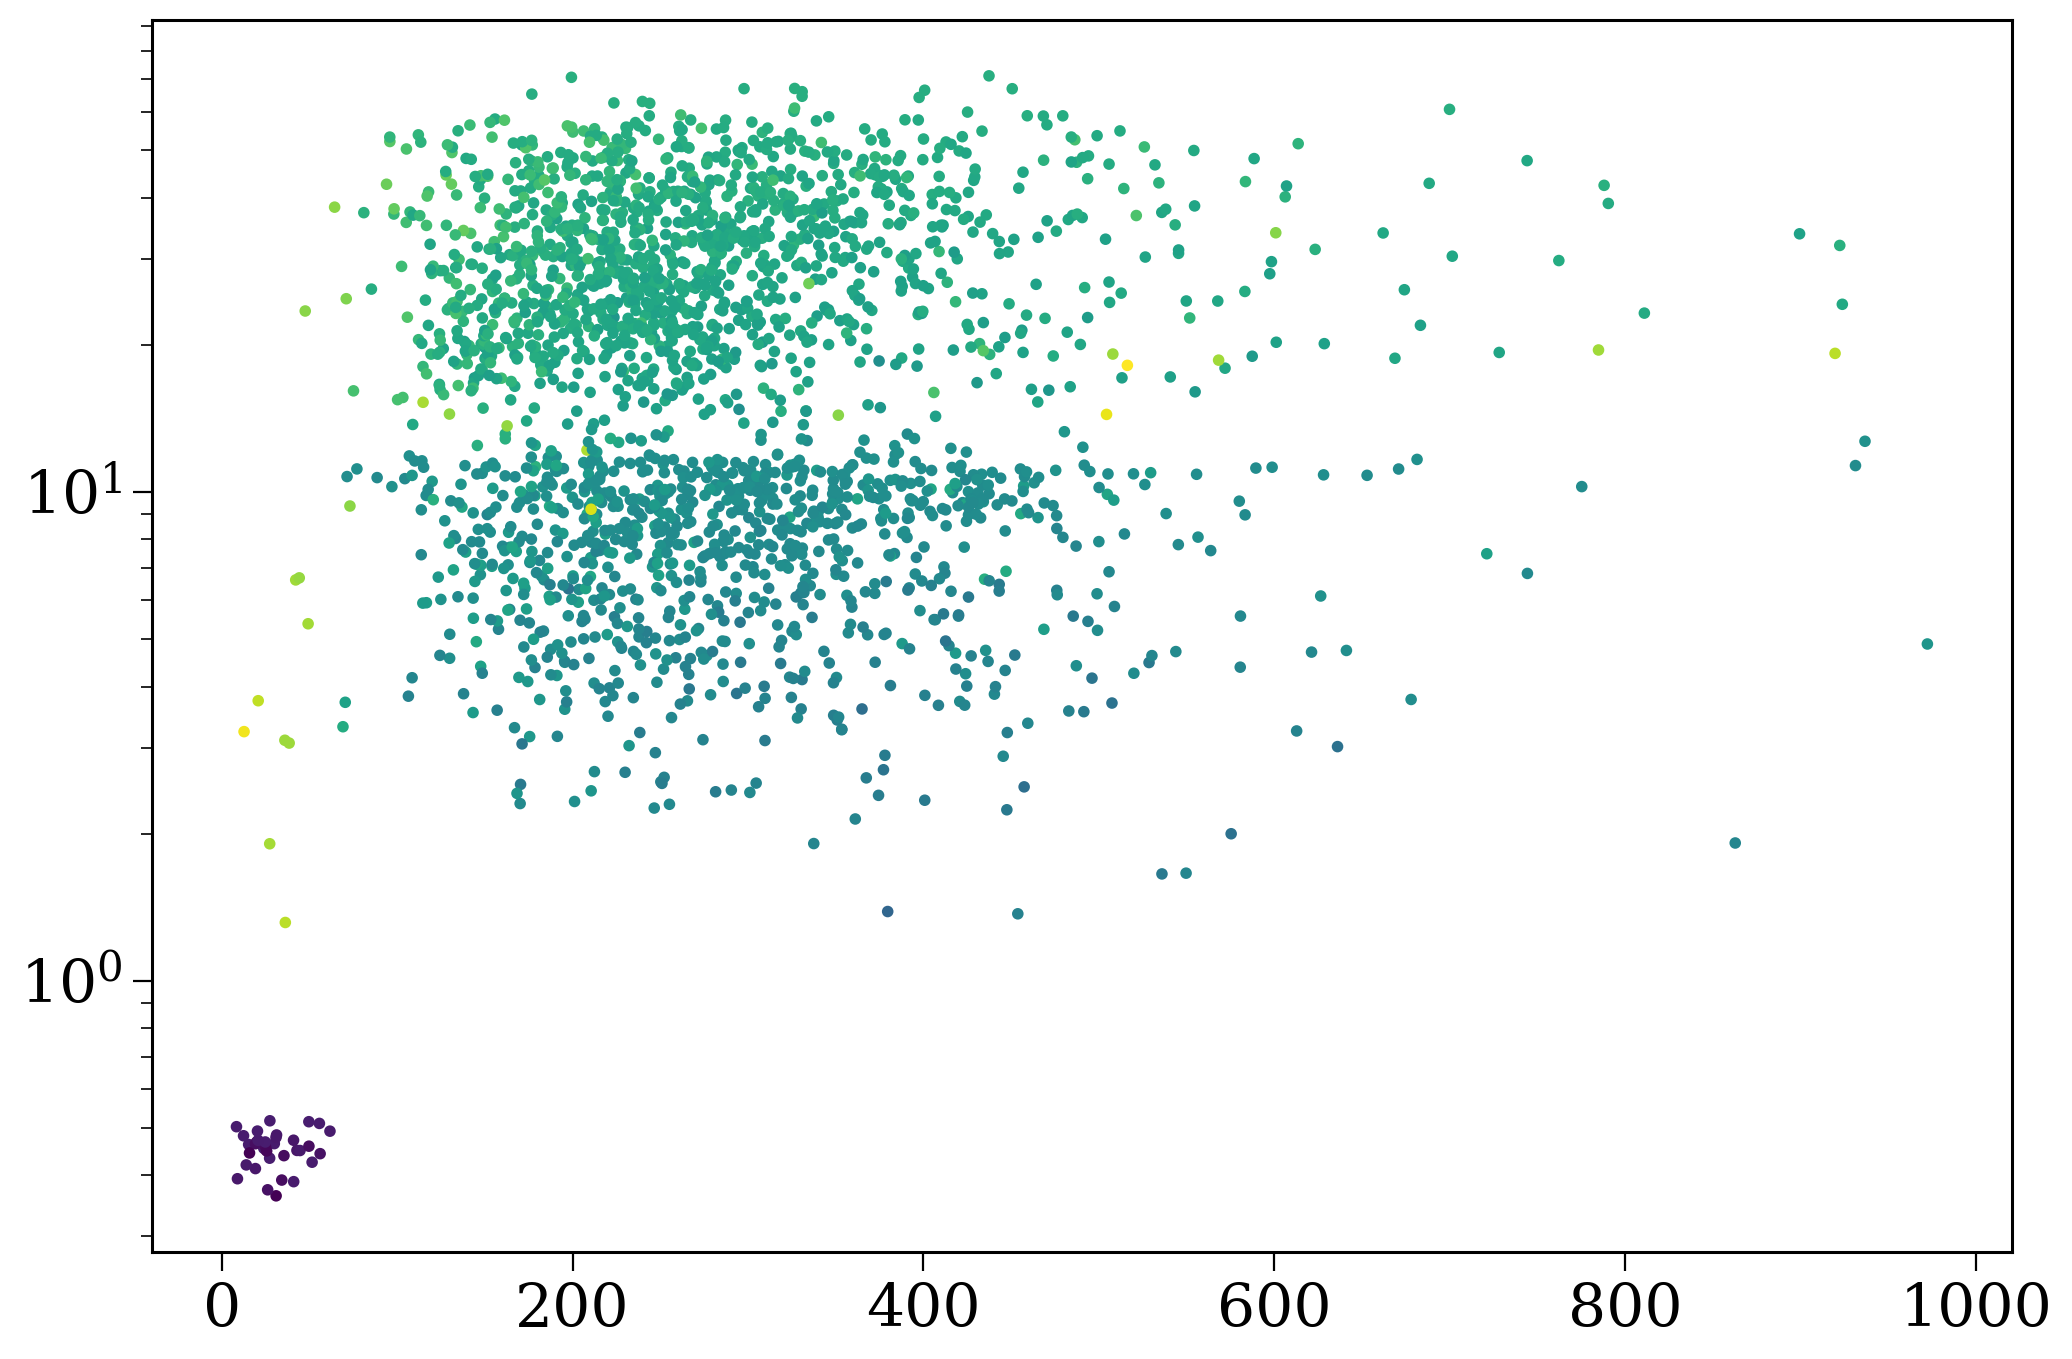

In [64]:
plt.scatter(tzo_kicks["natal_kick"], tzo_sn_states["mass_2"], c=np.log10(tzo_sn_states["sep"]), s=10)
plt.yscale("log")

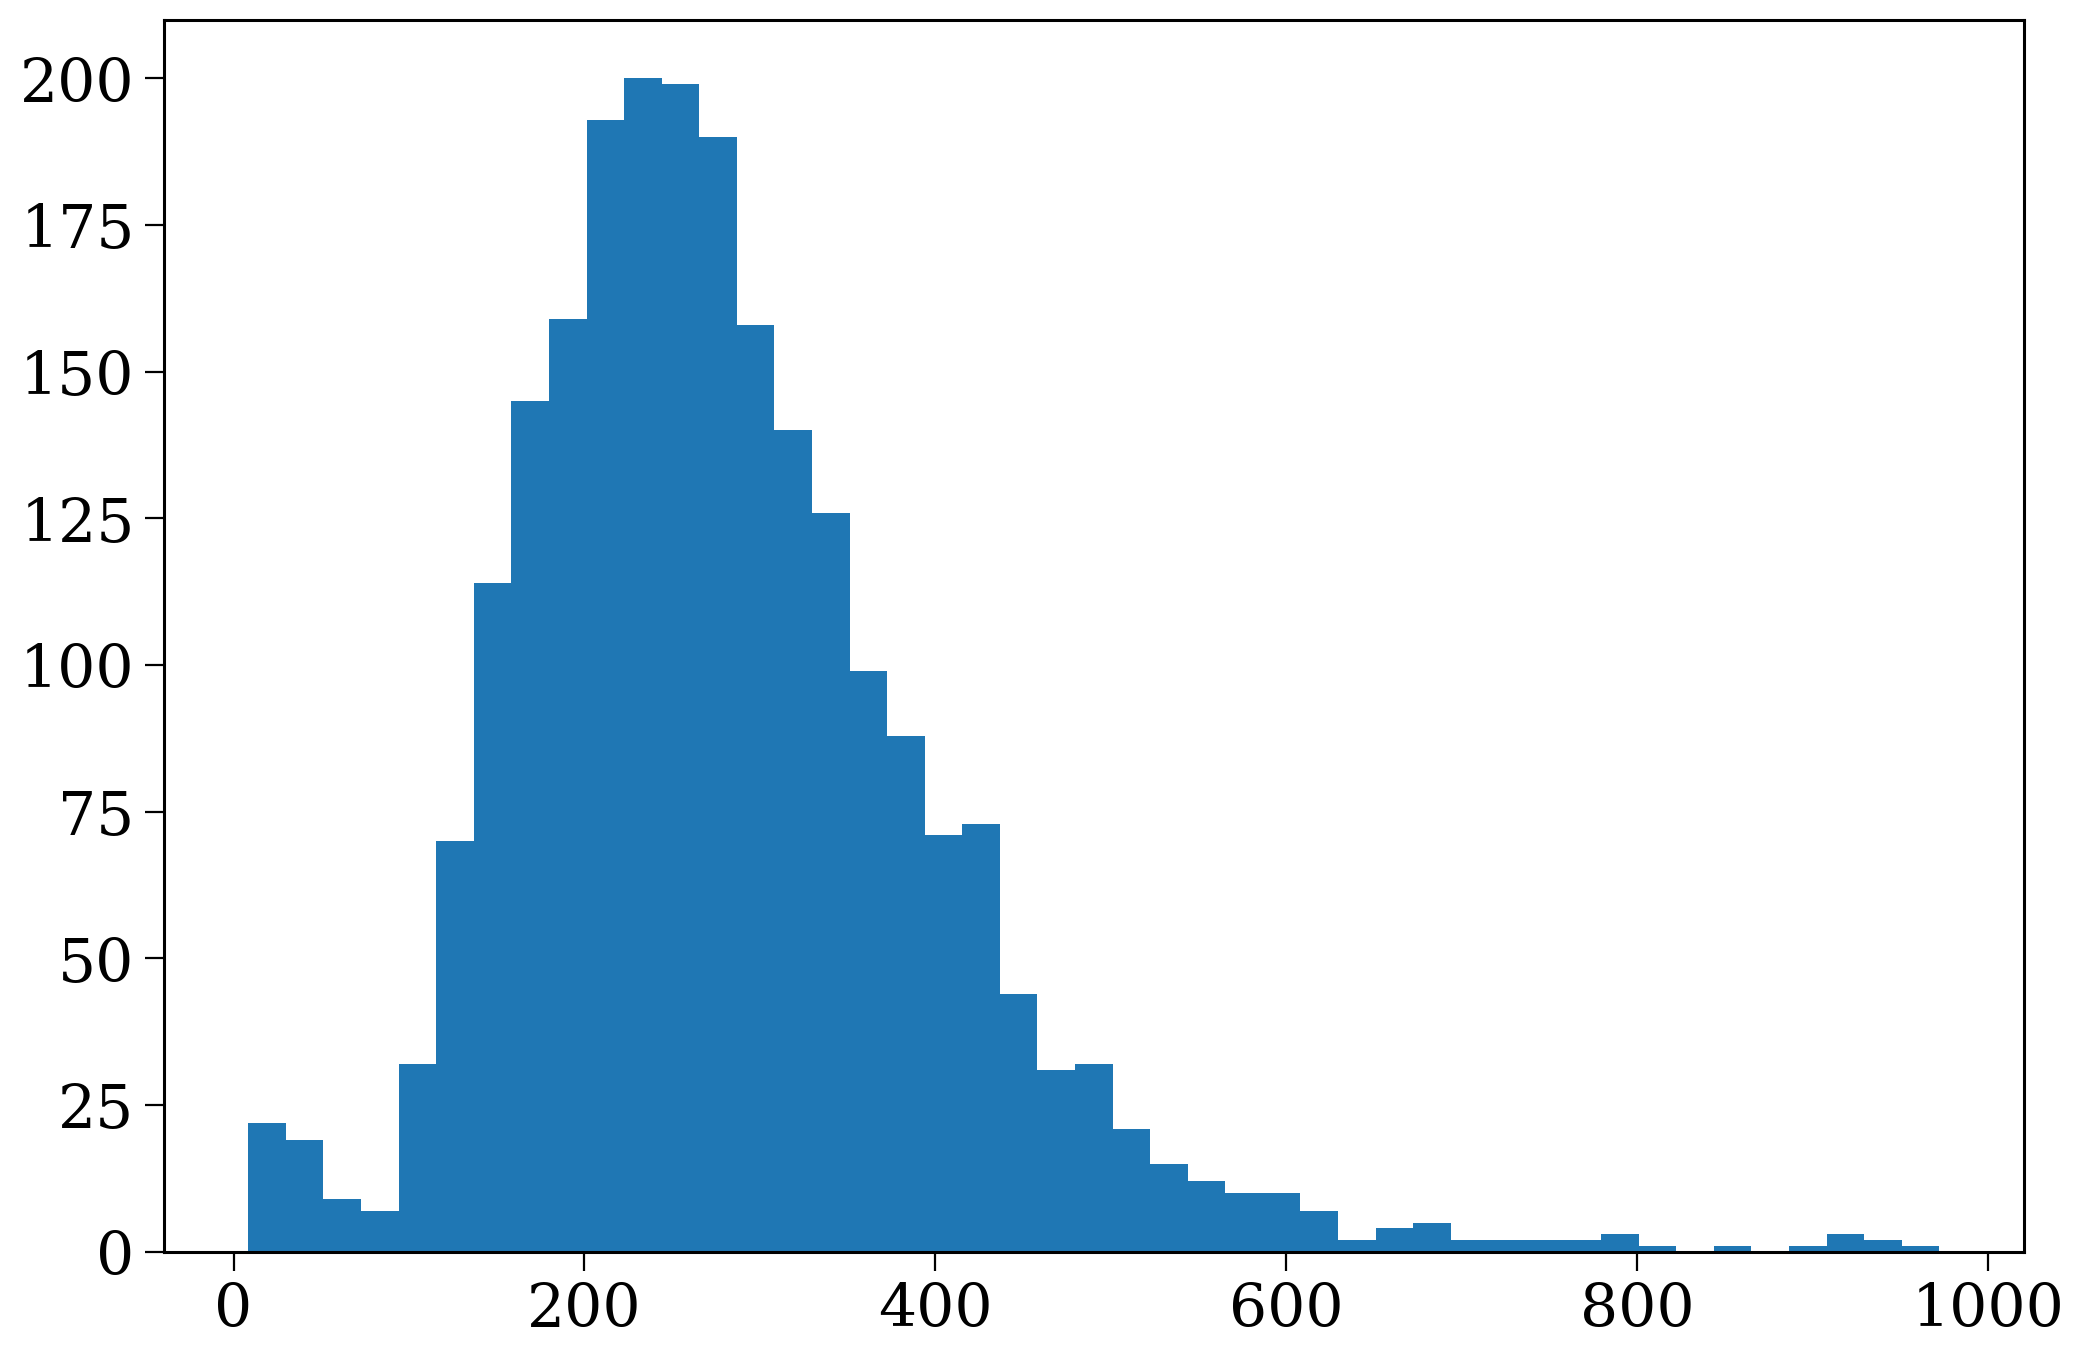

In [54]:
plt.hist(tzo_kicks["natal_kick"], bins="fd");

# Smaller test pop

In [48]:
p = cogsworth.pop.load("/mnt/home/twagg/ceph/pops/m11h-r-3-no-gal.h5", parts=["initial_binaries", "initial_galaxy"])

In [50]:
smaller = p[p.initC[p.initC["particle_id"].isin(np.random.choice(p.initC["particle_id"].max(), size=1000, replace=False))].index.values]

In [54]:
smaller.save('/mnt/home/twagg/ceph/pops/feedback-variations/variation-template.h5', overwrite=True)

In [68]:
p._orbits_file

'/mnt/home/twagg/ceph/pops/m11h-r-3-new-pot.h5'

In [31]:
t._initial_binaries

In [43]:
with h5.File("/mnt/home/twagg/ceph/pops/m11h-r-3-new-pot.h5", "r") as f:
    print(f["initial_galaxy"])

<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values']>


In [42]:
p.initial_galaxy.__dict__

{'_components': None,
 '_component_masses': None,
 '_size': 776895,
 '_tau': <Quantity [0.20088286, 0.20088286, 0.20088286, ..., 0.26248681, 0.26248681,
            0.26248681] Gyr>,
 '_Z': <Quantity [0.01437833, 0.01437833, 0.01437833, ..., 0.01668692, 0.01668692,
            0.01668692]>,
 '_x': <Quantity [-3.98832069, -3.98162811, -3.98492167, ...,  4.43895055,
             4.44097936,  4.43965703] kpc>,
 '_y': <Quantity [-6.56052814, -6.55631321, -6.5601527 , ...,  1.8269888 ,
             1.82719152,  1.83035055] kpc>,
 '_z': <Quantity [ 0.8917816 ,  0.88846793,  0.88991675, ..., -0.85161987,
            -0.85297398, -0.84957029] kpc>,
 '_which_comp': array(['FIRE', 'FIRE', 'FIRE', ..., 'FIRE', 'FIRE', 'FIRE'], dtype=object),
 '__citations__': ['cogsworth']}

In [39]:
smaller.initial_galaxy

<StarFormationHistory, size=75637>

In [34]:
p.initC["bhflag"]

0         1
1         1
2         1
3         1
4         1
         ..
776961    1
776962    1
776963    1
776964    1
776965    1
Name: bhflag, Length: 776895, dtype: int64